This notebook demonstrates the process of converting text to speech, accomplished through the following two main steps:
1. Predicting the phoneme durations using a Duration model.
2. Generating the corresponding waveform using the VITS model.

In [1]:
import torch  # isort:skip
from tfloader import load_tfdata
import json
from types import SimpleNamespace
from models import SynthesizerTrn, DurationNet
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [2]:
# global config
config_file = "config.json"
duration_model_path = "ckpts/duration_model.pth"
vits_model_path = "ckpts/generator.pth"
output_file = "clip.wav"
device = "cuda" if torch.cuda.is_available() else "cpu"
with open(config_file, "rb") as f:
    hps = json.load(f, object_hook=lambda x: SimpleNamespace(**x))

In [3]:
# load an example test data
ds = load_tfdata("data/tfdata", "test", 1, 0, 0, 1).as_numpy_iterator()
batch = next(ds)

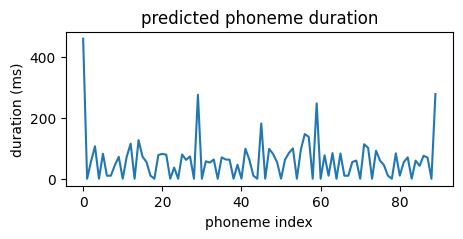

In [4]:
# predict phoneme duration
duration_net = DurationNet(hps.data.vocab_size, 64, 4).to(device)
duration_net.load_state_dict(torch.load(duration_model_path, map_location=device))
duration_net = duration_net.eval()
phone_length = torch.from_numpy(batch["phone_length"].copy()).long().to(device)
phone_idx = torch.from_numpy(batch["phone_idx"].copy()).long().to(device)
with torch.inference_mode():
    phone_duration = duration_net(phone_idx, phone_length)[:, :,  0] * 1000

plt.figure(figsize=(5, 2))
plt.plot(phone_duration[0])
plt.ylabel("duration (ms)")
plt.xlabel("phoneme index")
plt.title("predicted phoneme duration")
plt.show()

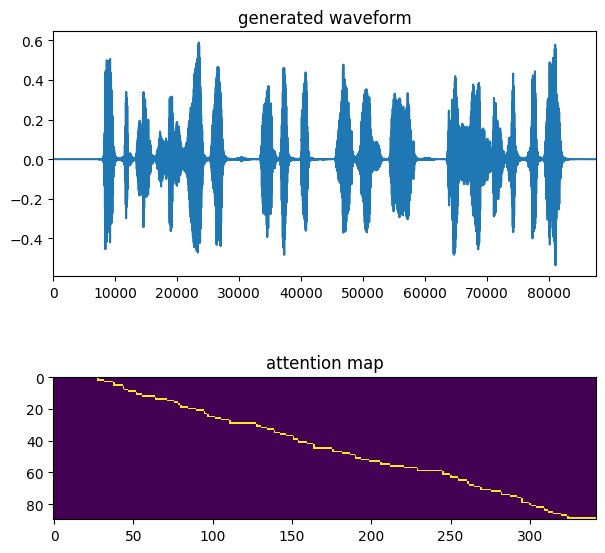

In [5]:
generator = SynthesizerTrn(
    hps.data.vocab_size, 
    hps.data.filter_length // 2 + 1, 
    hps.train.segment_size // hps.data.hop_length, 
    **vars(hps.model)
).to(device)
ckpt = torch.load(vits_model_path, map_location=device)
params = {}
for k, v in ckpt["net_g"].items():
    k = k[7:] if k.startswith("module.") else k
    params[k] = v
generator.load_state_dict(params)
del ckpt, params
generator = generator.eval()
end_time = torch.cumsum(phone_duration, dim=-1)
start_time = end_time - phone_duration
start_frame = (start_time * hps.data.sampling_rate / hps.data.hop_length / 1000).int()
end_frame = (end_time * hps.data.sampling_rate / hps.data.hop_length / 1000).int()
spec_length = end_frame.max(dim=-1).values
# make sure end_frame > start_frame, at least 1 frame
end_frame = torch.max(end_frame, start_frame + 1)
pos = torch.arange(0, spec_length.item(), device=device)
attn = torch.logical_and(
    pos[None, :, None] >= start_frame[:, None, :], 
    pos[None, :, None] < end_frame[:, None, :]
).float()
with torch.inference_mode():
    y_hat = generator.infer(phone_idx, phone_length, spec_length, attn, max_len=1000, noise_scale=0.667)[0]
y_hat = y_hat[0, 0].data.cpu().numpy()
wavfile.write(output_file, hps.data.sampling_rate, y_hat)
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.plot(y_hat)
plt.xlim(0, len(y_hat))
plt.title("generated waveform")
plt.subplot(2, 1, 2)
plt.imshow(attn[0].T, interpolation="nearest")
plt.title("attention map")
plt.show()